# Connectivity inference with PAGA

In this section, we employed [PAGA](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1663-x) to analyze cellular connectivity patterns with odontoblasts. This analysis helped identify clusters potentially involved in odontogenesis across different samples.

## Environment Set Up

In [222]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from PyComplexHeatmap import *

In [10]:
%config InlineBackend.figure_format = 'retina'  # For high-resolution displays
%config InlineBackend.print_figure_kwargs = {'dpi': 200}  # Set DPI

In [9]:
sc.settings.figdir = "../../results/trajectory/20241119_trajectory_embedding/"

In [2]:
mes = sc.read("../../processed_data/integrated_data/20241118_mes.h5ad")

In [3]:
mes

AnnData object with n_obs × n_vars = 152988 × 36303
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_RNA', 'nFeature_RNA', 'coarse_anno_1', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'size_factors', 'Sample', 'Project', 'Core_datasets', 'Mandibular_Maxillary', 'Molar_Incisor', 'Tooth.position', 'Histology', 'Sex', 'Gene.Type', 'Knockout_gene', 'Cre', 'Treatment', 'FACs', 'Age', 'Stage', 'Development.stage', 'Disease', 'Strain', 'Dissociation_enzyme', 'Machine', 'Species', 'Related.assay', 'Journal', 'Data.Source', 'Data.location', 'new_totals_log', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'scDblFinder_class', 'leiden', 'anno_level_1', 'Cell_ID', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'leiden_clusters_level_3', 'leiden_clusters_level_4', 'leiden_

## PAGA Inferecence

In [4]:
sc.pp.neighbors(mes,n_neighbors=20, n_pcs=30,use_rep="X_X_SCANVI")

2024-11-19 20:28:58.859531: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 20:29:00.842126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
sc.tl.paga(mes, groups="C9_named")

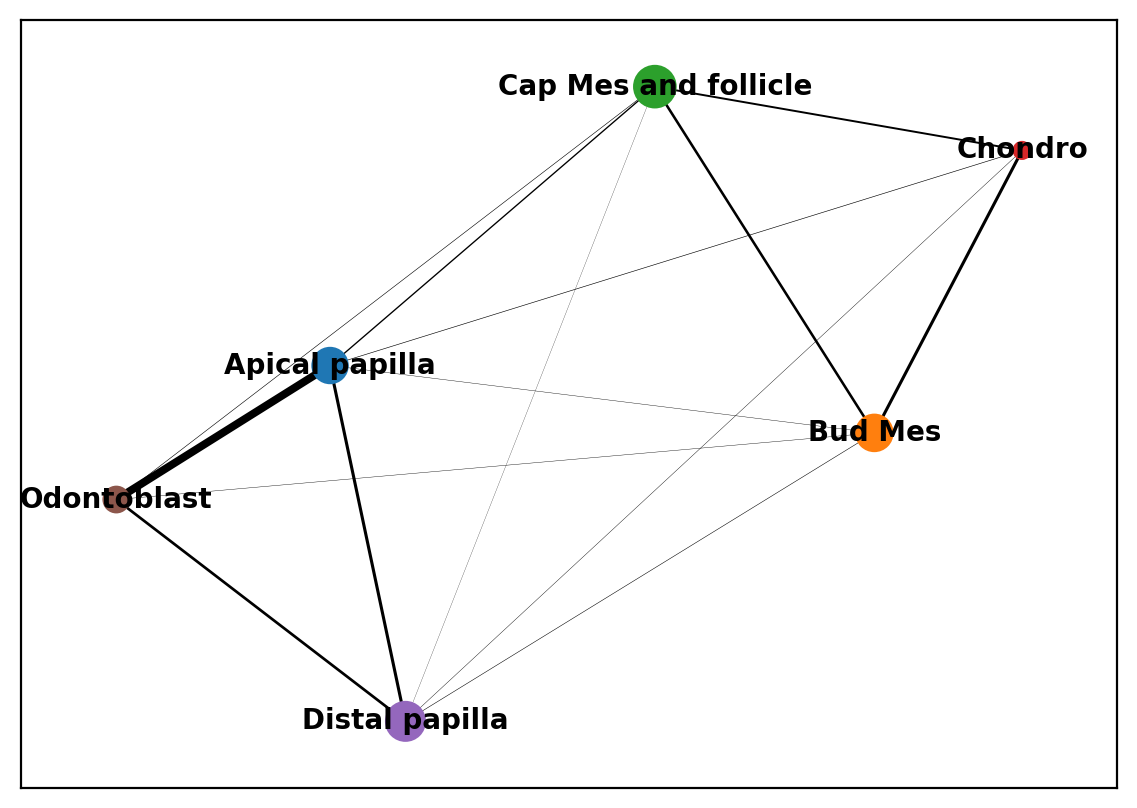

In [11]:
sc.pl.paga(mes, color=["C9_named"],save="_rawpaga_C9.pdf")

In [14]:
paga1 = mes.uns["paga"].copy()

In [42]:
diffmap = pd.read_csv("../../processed_data/framework/embedding/20241119_mes_diffmap_10.csv",index_col=0)

In [43]:
diffArray = diffmap.to_numpy()

In [44]:
mes.obsm["X_diffmap"] = diffArray

In [45]:
diffmap_eval = pd.read_csv("../../processed_data/framework/embedding/20241119_mes_diffmap_10_uns_evals.csv",index_col=0)

In [48]:
mes.uns["diffmap_evals"] = np.array(diffmap_eval)

In [50]:
sc.pp.neighbors(mes, n_neighbors=30, use_rep="X_diffmap",n_pcs=10)

In [51]:
sc.tl.paga(mes, groups="C9_named")

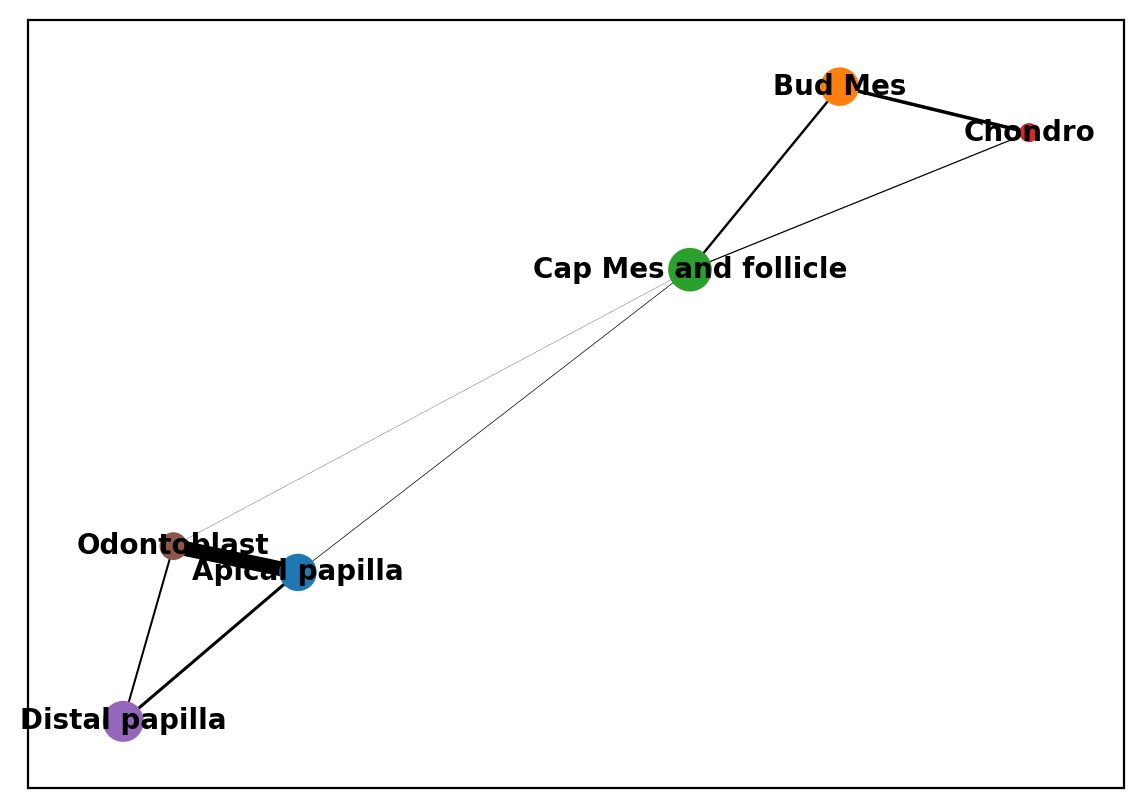

In [52]:
sc.pl.paga(mes, color=["C9_named"],save="_diffmap_paga_C9.pdf")

In [59]:
mes.obsp["connectivities_C9"] = mes.obsp["connectivities"].copy()

## Sample-level PAGA inference

Here, I turned into sample-level PAGA for better understanding differentiation in samples.

In [75]:
scMeta = pd.read_csv("../../processed_data/metadata/scMetadata_latest.csv",index_col=0)

In [190]:
mes_obs = scMeta.loc[mes.obs_names]

In [80]:
mes.obs["Sample"] = scMeta.loc[mes.obs_names]["Sample"].copy()

In [81]:
mes.obs["sample_C9"]=mes.obs["Sample"].astype("str")+"_sep_"+ mes.obs["C9_named"].astype("str")

In [83]:
mes.obs["sample_C9"] = mes.obs["sample_C9"].astype('category')

In [60]:
sc.tl.paga(mes, groups='sample_C9')

In [61]:
connectivePd=mes.uns["paga"]["connectivities"].toarray()
connectivePd=pd.DataFrame(connectivePd)

In [136]:
connectivePd=connectivePd.set_index(mes.obs["sample_C9"].cat.categories)
connectivePd.columns=mes.obs["sample_C9"].cat.categories

In [138]:
labelCategory=np.array(mes.obs["sample_C9"].cat.categories)
labelCategory= np.array(["__".join(s.split("_sep_")[:-1]) for s in labelCategory])
df = pd.DataFrame(True, columns=labelCategory, index=labelCategory)
for i in labelCategory:
    df.loc[i,i] = False
df=df.set_index(mes.obs["sample_C9"].cat.categories)
df.columns=mes.obs["sample_C9"].cat.categories
connectivePd_masked = connectivePd.mask(df, 0)

In [113]:
df=df.set_index(mes.obs["sample_C9"].cat.categories)

In [116]:
df.columns=mes.obs["sample_C9"].cat.categories

In [140]:
osteoblastCategory= np.array([s.split("_sep_")[-1] for s in np.array(mes.obs["sample_C9"].cat.categories)])
osteoLogic=osteoblastCategory=="Odontoblast"
connectivePd_masked=connectivePd_masked.iloc[osteoLogic,:]
osteoSum=connectivePd_masked.sum()

In [141]:
data = {'Column 1': osteoSum, 'Column 2': labelCategory,'Column 3':osteoblastCategory}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

In [153]:
df_wide = df.pivot(index='Column 2', columns='Column 3', values='Column 1')
df_wide=df_wide.loc[:, [ 'Cap Mes and follicle','Apical papilla', 'Distal papilla']]

# calculate row sums and get index of rows where sum is 0
row_sums = df_wide.sum(axis=1)
zero_sum_rows = row_sums[row_sums == 0].index
df_wide=df_wide.fillna(0)
# drop rows with zero sum
df_wide = df_wide.drop(index=zero_sum_rows)

In [179]:
# Add very small random noise to duplicates
def add_small_noise(df, noise_level=1e-2):
    df_new = df.copy()
    duplicated_rows = df_new.duplicated()
    
    # Add noise only to duplicated rows
    noise = np.random.normal(0, noise_level, size=df_new.shape)
    df_new += noise
        
    return df_new

# Apply the function
df_wide_modified = add_small_noise(df_wide)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..


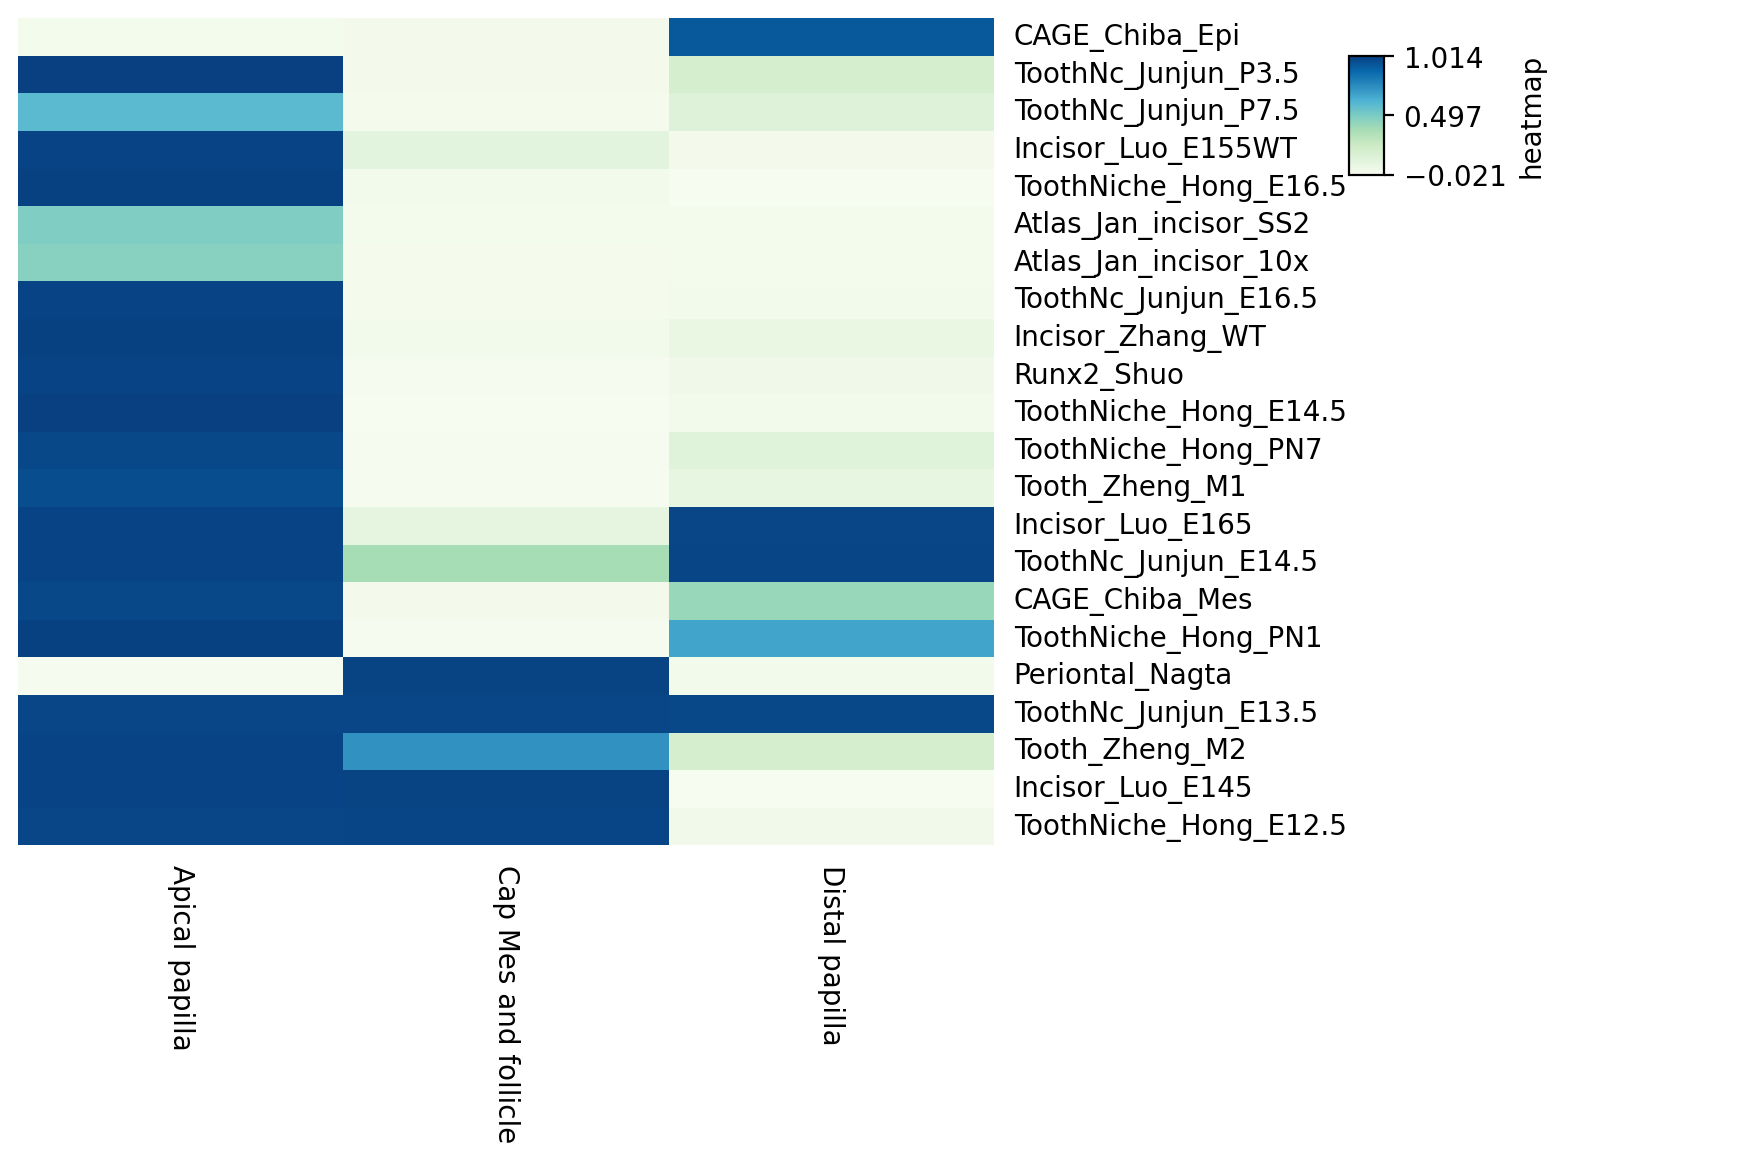

In [181]:
ClusterMapPlotter(data=df_wide_modified,
                       linewidths=0.0001,cmap="GnBu",linecolor = 'white',
                       show_rownames=True,show_colnames=True,legend_width=50)

In [232]:
df_new = mes_obs[["Sample",'Age', 'Stage', 'Development stage','Mandibular_Maxillary', 
                    'Molar_Incisor', 'Tooth position', 'Histology']]
table=df_new.groupby("Sample")[["Sample",'Age', 'Stage', 'Development stage','Mandibular_Maxillary', 
                    'Molar_Incisor', 'Tooth position', 'Histology']].first()
table=table.set_index("Sample")
table=table.loc[df_wide.index.to_numpy(),: ]


In [233]:
table["Molar_Incisor"].unique()

array(['Incisor', 'Molar'], dtype=object)

In [234]:
table["Stage"] = pd.Categorical(table["Stage"], categories=['Embryo', 'Postnatal', 'Young Adult'], ordered=True)
table["Development stage"] = pd.Categorical(table["Development stage"], 
                                            categories=['Thickening', 'Bud', 'Cap', 'Bell', 'Erupted'], ordered=True)
table["Mandibular_Maxillary"] = pd.Categorical(table["Mandibular_Maxillary"], 
                                            categories=['Mandibular', 'Not state'], ordered=True)
table["Molar_Incisor"] = pd.Categorical(table["Molar_Incisor"], 
                                            categories=['Molar', 'Incisor',"Not state"], ordered=True)
table["Age"] = pd.Categorical(table["Age"],  categories=[ 'PN7', 'E12.5',  'E13.5','E14.5', 'E15.5',
                                                        'E16.5', 'PN1', 'PN3.5', 'PN5','PN7.5',
                                                        'PN25', 'M1','M2-4'], ordered=True)
table["Histology"] = pd.Categorical(table["Histology"],  categories=[ 'Dental pulp', 'Epithelium', 'Mesenchyme',
                                                                     'tooth germ', 'Periodontal space',
                                                                     'tooth and its surrounding tissue','Not provided'], ordered=True)

In [235]:
color_map_stage = dict(zip([ 'Embryo', 'Postnatal', 'Young Adult'],
                         sns.color_palette("ch:s=.25,rot=-.25", n_colors=3)))
color_map_age = dict(zip(table["Age"].values.categories,
                         sns.color_palette("ch:s=.25,rot=-.25", n_colors=len(table["Age"].values.categories))))
color_map_Development = dict(zip(table["Development stage"].values.categories,
                         sns.color_palette('Spectral', n_colors=len(table["Development stage"].values.categories))))
color_map_mandibular = dict(zip(table["Mandibular_Maxillary"].unique(),
                         sns.color_palette('Spectral', n_colors=len(table["Mandibular_Maxillary"].unique()))))
color_map_Molar_Incisor = dict(zip(table["Molar_Incisor"].values.categories,
                         sns.color_palette('Spectral', n_colors=len(table["Molar_Incisor"].unique()))))
color_map_Histology = dict(zip(table["Histology"].values.categories,
                         sns.color_palette('Spectral', n_colors=len(table["Histology"].values.categories))))


In [236]:
annoRow=table
annoRow.index=df_wide.index


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


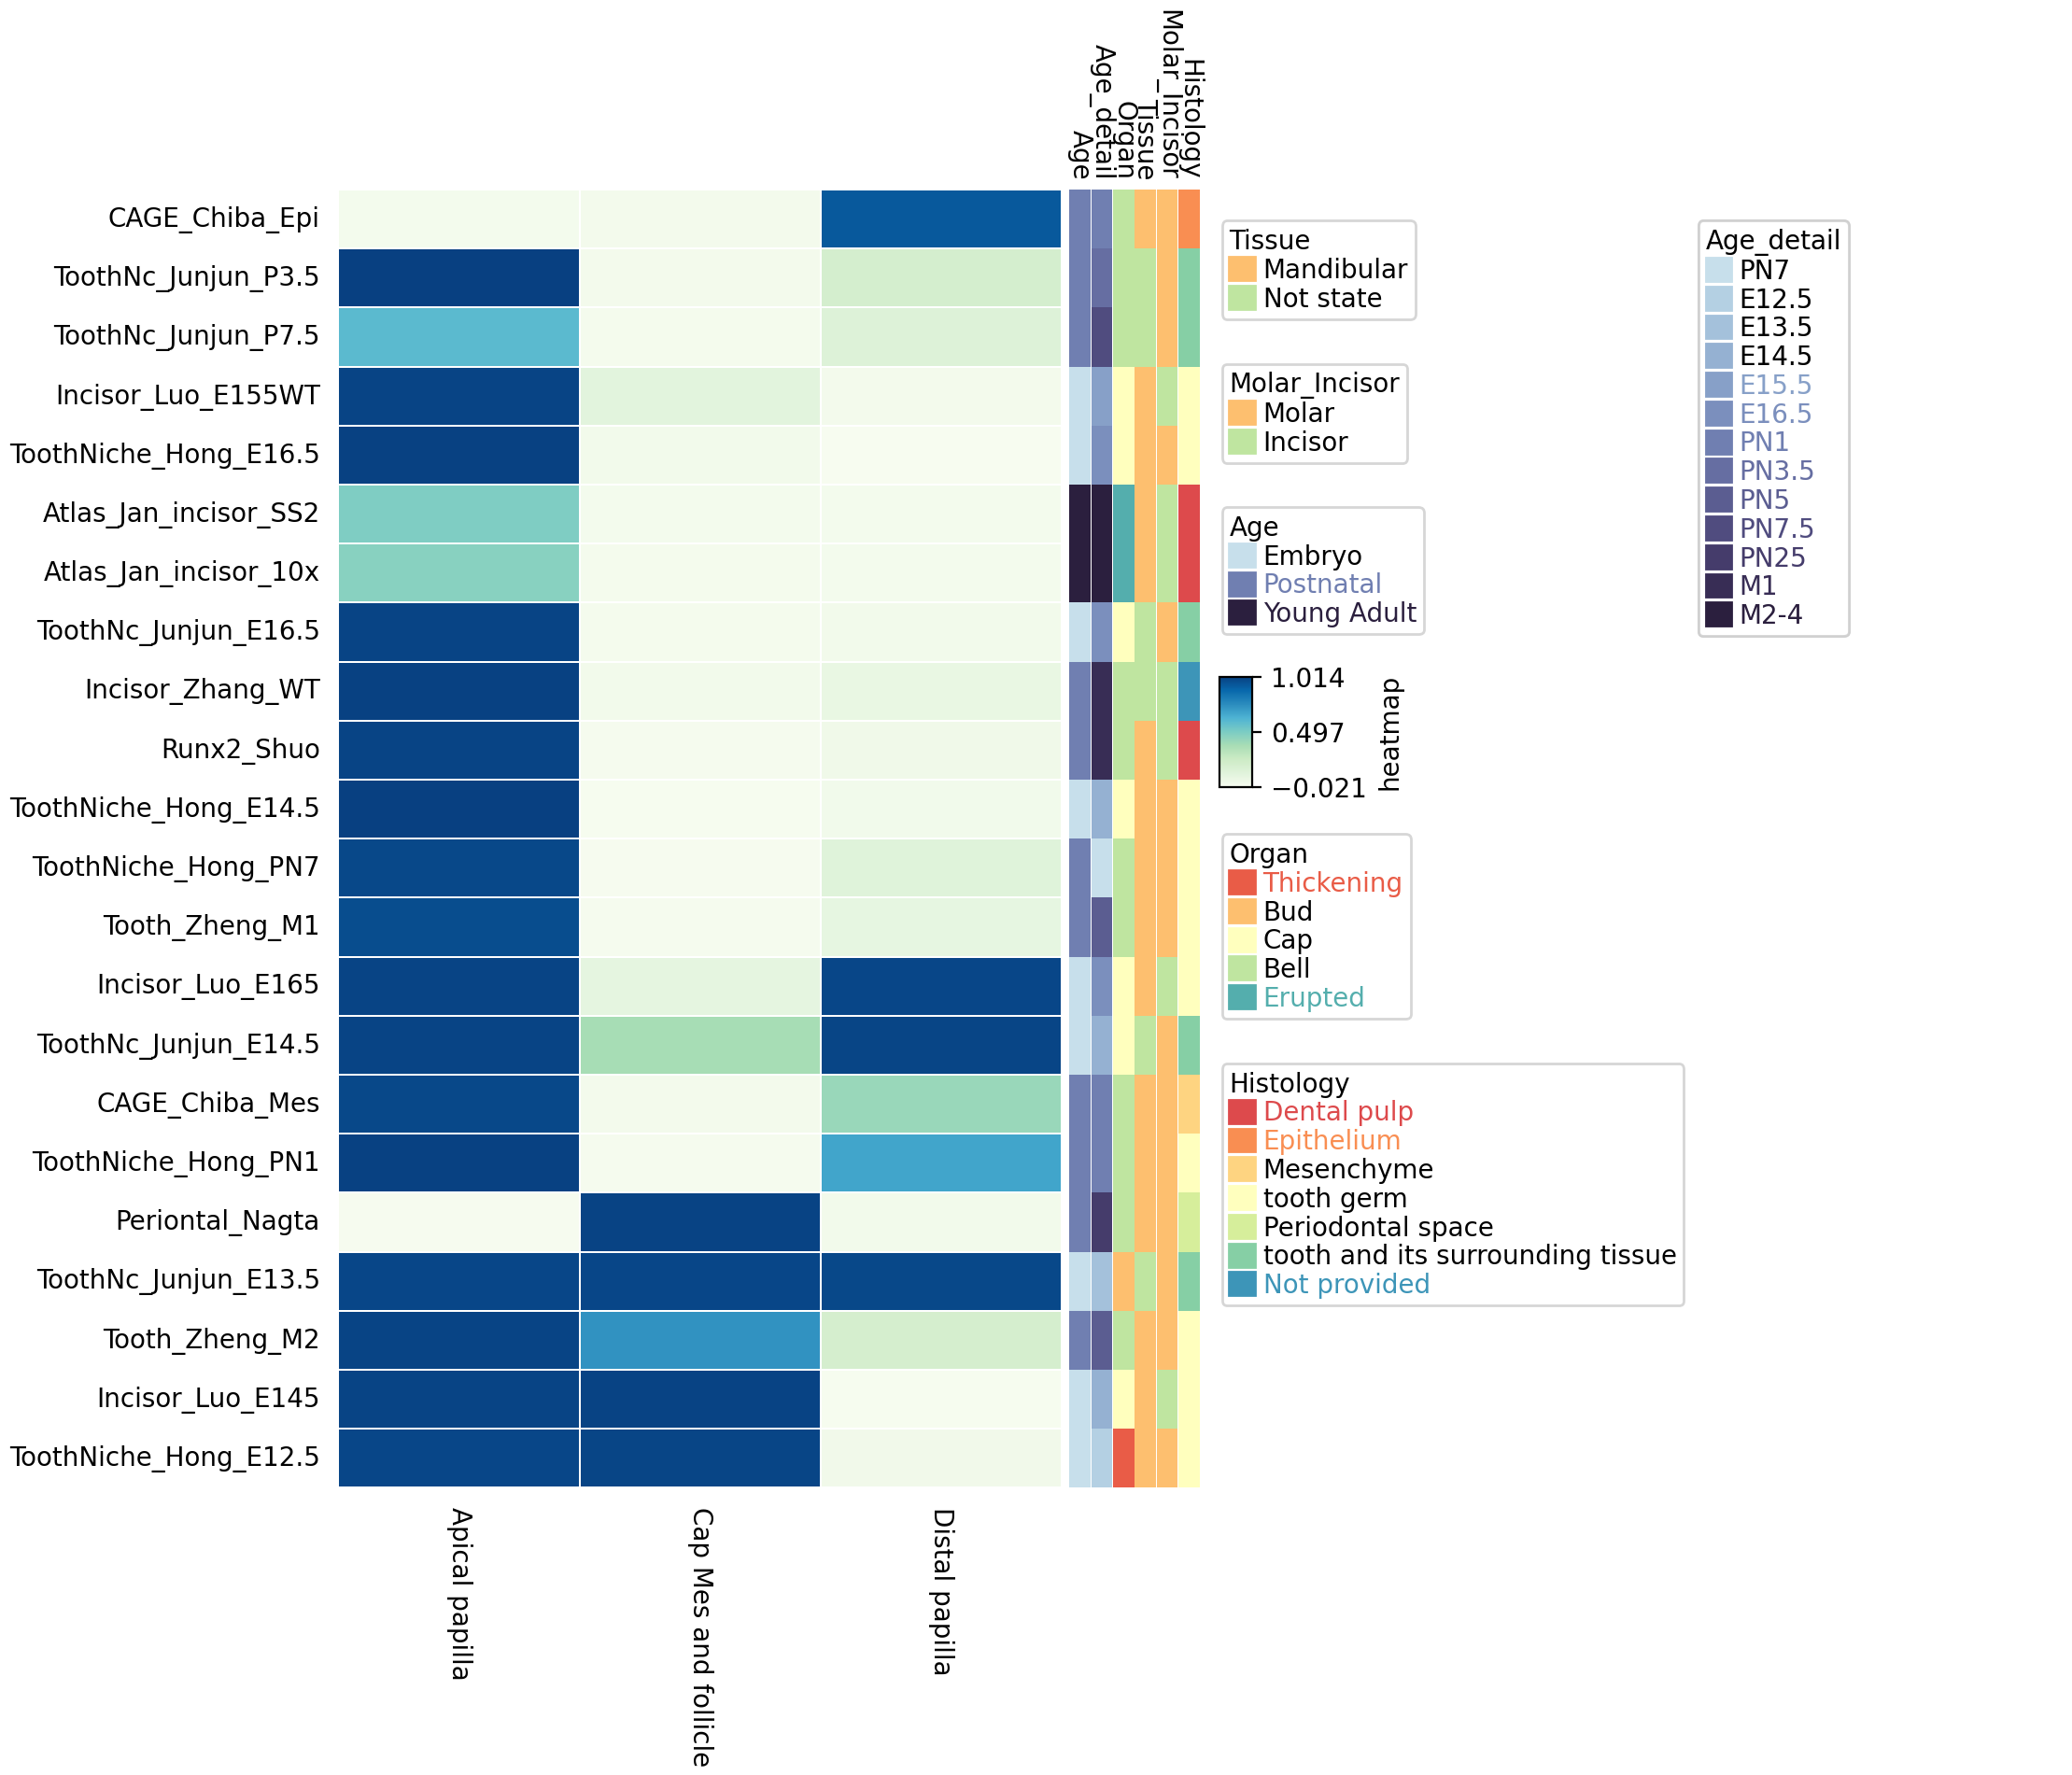

In [238]:
annoRow=table
annoRow.index=df_wide.index
row_ha = HeatmapAnnotation(Age=anno_simple(annoRow["Stage"],colors=color_map_stage),
                           Age_detail=anno_simple(annoRow["Age"],colors=color_map_age),
                           Organ=anno_simple(annoRow["Development stage"],colors=color_map_Development),
                           Tissue=anno_simple(annoRow["Mandibular_Maxillary"],colors=color_map_mandibular),
                           Molar_Incisor=anno_simple(annoRow["Molar_Incisor"],colors=color_map_Molar_Incisor),
                           Histology=anno_simple(annoRow["Histology"],colors=color_map_Histology),axis=0)
plt.figure(figsize=(6, 8))

cm = ClusterMapPlotter(data=df_wide_modified,right_annotation=row_ha,
                       linewidths=0.005,cmap="GnBu",linecolor = 'white',
                       show_rownames=True,show_colnames=True,legend_width=50)
plt.savefig("../../results/trajectory/20241122_paga/20241121_paga_hm.pdf",dpi=300, bbox_inches='tight')

In [240]:
df_wide_modified.to_csv("../../process/trajectory/20241122_paga/paga_hm_table.csv")